# **Homework 3: Object tracking**



Objectives:
* Get familiar with object detection with YOLOv3.
* Understand the basic pipeline of object tracking.
* Solve tracking problem with YOLO and Kalman Filter.
* Implement some visualization.

Total points: 100

If any questions, please contact the TAs via TA hours, or email.


# **Download and install**

In [2]:
try:
    !rmdir /s /q HW3_object_track
except:
    pass

# Get some essential codes
!git clone https://github.com/JamesLiang819/HW3_object_track.git

# Download pre-trained weights for yolov3
import urllib.request

url = "https://pjreddie.com/media/files/yolov3.weights"
filename = "yolov3.weights"

urllib.request.urlretrieve(url, filename)

# Install filterpy
!pip install filterpy

Cloning into 'HW3_object_track'...


In [3]:
from __future__ import print_function

# Basic models and utils
from HW3_object_track.models import *
from HW3_object_track.utils import *

# System
import os, sys, time, datetime, random
import argparse
from numba import jit

# Data processing
import numpy as np
from scipy.optimize import linear_sum_assignment as linear_assignment
from filterpy.kalman import KalmanFilter

# Pytorch
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

# Image processing
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from skimage import io

# **Object detection with pre-trained YOLOv3**

## **About the YOLOv3**

YOLOv3 (You Only Look Once, Version 3) is a Convolutional Neural Network (CNN) for performing object detection in real-time.

It allows the model to look at the whole image at test time, so its predictions are informed by the global context in the image.

YOLO “scores” regions based on their similarities to predefined classes.

High-scoring regions are noted as positive detections of whatever class they most closely identify with.

For more details, please refer to [YOLO](https://arxiv.org/pdf/1506.02640.pdf) and [YOLOv3](https://arxiv.org/pdf/1804.02767.pdf).

In [4]:
config_path='HW3_object_track/config/yolov3.cfg'
weights_path='yolov3.weights'
class_path='HW3_object_track/config/coco.names'
img_size=416
conf_thres=0.3
nms_thres=0.1

# Get bounding-box colors
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load model and weights (15pts)


In [65]:
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path=weights_path) # (5pts)TODO: Load weights from pretrained yolov3 weights
model.to(device) # (5pts)TODO: Put model into cuda device
model.eval() # (5pts)TODO: Set model to eval mode
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

c:\Users\Ryan Barry\OneDrive - rit.edu\Laptop Backup\Desktop\RIT\Robot Perception\Homework\HW3\venv\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Detect Image

In [66]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

## Load image and get detections (15pts)

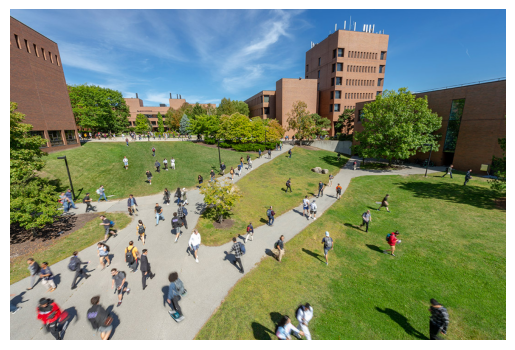

In [82]:
# (15pts)TODO: Load image and get detections
# hint: from hw2###
img_path = "C:\\Users\\Ryan Barry\\OneDrive - rit.edu\\Laptop Backup\\Desktop\\RIT\\Robot Perception\\Homework\\HW3\\HW3_object_track\\images\\rit.jpg"
original_image = Image.open(img_path, mode='r')
# original_image = original_image.convert('RGB')
detections = detect_image(original_image)
# detections = detections.cpu().numpy()
plt.imshow(original_image)
plt.axis('off')
plt.show()

## Detection visulization (10pts)

Here's an example:
https://drive.google.com/file/d/1MVWqV3U4JyScBE3N4bE7Sri3FL7v74t-/view?usp=sharing

You can customize everything, such as the colors, thickness of the box...
The text is not required, but boxes for objects of the same kind should have the same color.


C:\Users\Ryan Barry\AppData\Local\Temp\ipykernel_32900\2556146469.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]


<Figure size 640x480 with 0 Axes>

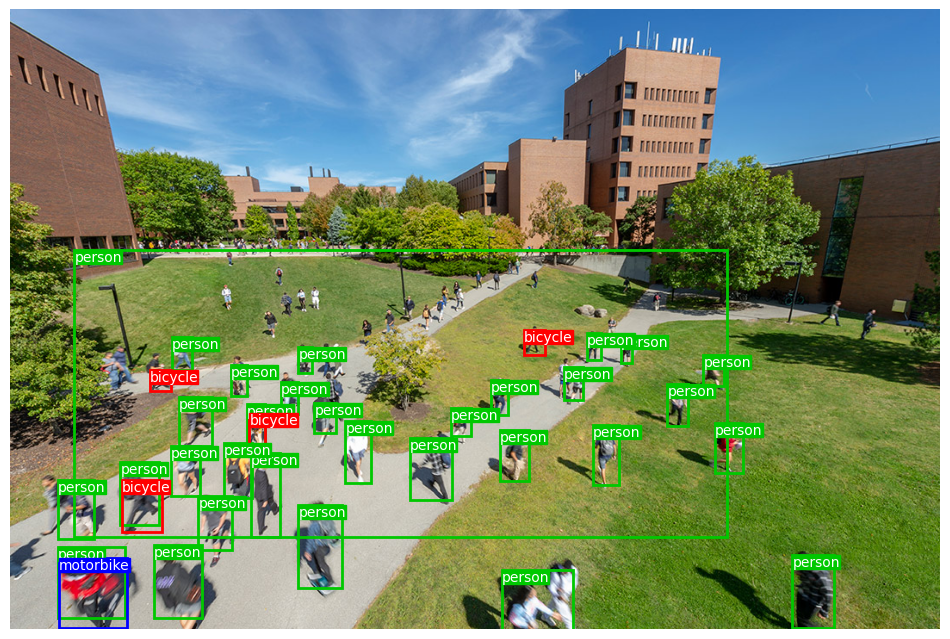

In [90]:
img = np.array(original_image)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x


if detections is not None:
    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # browse detections and draw bounding boxes
    for detection in detections:
        x1, y1, x2, y2, conf, cls_conf, cls_pred = detection.cpu().numpy()
        box_h = ((y2 - y1) / unpad_h) * img.shape[0]
        box_w = ((x2 - x1) / unpad_w) * img.shape[1]
        y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
        x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
        color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]

        # Normalize RGBA color values to the range of 0-1
        color = tuple(c / 255 for c in color)

        bbox = patches.Rectangle((x1, y1), box_w, box_h,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)

        plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                 bbox={'color': color, 'pad': 0})

           
plt.axis('off')
# save image
plt.savefig(img_path.replace(".jpg", "-detections.jpg"), bbox_inches='tight', pad_inches=0.0)
plt.show()

# Object tracking

## Utils

### IoU (5pts)

In [77]:
@jit
def iou(bb_test,bb_gt):
  """
  Computes IoU between two bboxes in the form [x1,y1,x2,y2]
  """
  #(5pts)TODO: calculate IoU of two boxes
  # hint: IoU = overlapping_area / total_area_of_two_boxes

  # Determine the coordinates of the intersection rectangle
  x_left = max(bb_test[0], bb_gt[0])
  y_top = max(bb_test[1], bb_gt[1])
  x_right = min(bb_test[2], bb_gt[2])
  y_bottom = min(bb_test[3], bb_gt[3])

  if x_right < x_left or y_bottom < y_top:
      return 0.0

  # Compute the area of intersection rectangle
  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  # Compute the area of both the prediction and ground-truth rectangles
  bb_test_area = (bb_test[2] - bb_test[0]) * (bb_test[3] - bb_test[1])
  bb_gt_area = (bb_gt[2] - bb_gt[0]) * (bb_gt[3] - bb_gt[1])

  # Compute the intersection over union
  iou = intersection_area / float(bb_test_area + bb_gt_area - intersection_area)

  # Return the intersection over union value
  return iou

C:\Users\Ryan Barry\AppData\Local\Temp\ipykernel_32900\4140100969.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit


### Convert (10pts)

In [78]:
def convert_bbox_to_z(bbox):
  """
  Takes a bounding box in the form [x1,y1,x2,y2] and returns z in the form
    [x,y,s,r] where x,y is the centre of the box and s is the scale/area and r is
    the aspect ratio, width/height

  For example, we have a rectangle input [0,0,200,100], (0,0) is the coordinate of
  top left corner, (200,100) is bottom right corner. The output should be [100.0, 50.0, 20000.0, 2.0]
  (100, 50) is the center of rectangle, 20000 is the area(200 * 100), 2.0 is width/height
  """

  #(5pts)TODO: generate your x, y, s, r
  w = bbox[2] - bbox[0]
  h = bbox[3] - bbox[1]
  x = bbox[0] + (w / 2)
  y = bbox[1] + (h / 2)
  s = w * h
  r = w / h
  

  return np.array([x,y,s,r]).reshape((4,1))

def convert_x_to_bbox(x,score=None):
  """
  Takes a bounding box in the centre form [x,y,s,r] and returns it in the form
    [x1,y1,x2,y2] where x1,y1 is the top left and x2,y2 is the bottom right,
    inverse of convert_bbox_to_z()
  """

  #(5pts)TODO: generate your x1, y1, x2, y2
  w = np.sqrt(x[2] * x[3])
  h = x[2] / w
  x1 = x[0] - (w / 2)
  y1 = x[1] - (h / 2)
  x2 = x1 + w
  y2 = y1 + h

  if(score==None):
    return np.array([x1,y1,x2,y2]).reshape((1,4))
  else:
    return np.array([x1,y1,x2,y2,score]).reshape((1,5))

### KalmanBoxTracker (20pts)

In [174]:
class KalmanBoxTracker(object):
  """
  This class represents the internel state of individual tracked objects observed as bbox.
  """
  count = 0
  def __init__(self,bbox):
    """
    Initialises a tracker using initial bounding box.
    In the tracking model, we approximate the inter-frame displacements
    of each object with a linear constant velocity model.

    State vector X = [x, y, s, r, Vx, Vy, Vs]
    Measurement vector Z = [x, y, s, r], in real implementation, it should have
    the same size as X, please use 0 to fill in the blanks.

    (x,y) is coordinate of central point, s is scale/area and r is aspect ratio,
    Vx, Vy, Vs are the "velocity" we simulate. And we consider the aspect ratio to
    be constant, so we don't have a Vr.

    For the measurement vector z, we have x, y, s, r only, because there's no way
    we can detect their velocities. What we can know from every frame is the box only.

    """
    #define constant velocity model
    self.kf = KalmanFilter(dim_x=7, dim_z=4)

    # (20pts)TODO: define state transition matrix F and measurement matrix H
    # hint: Please read the function docstring carefully, remember we are doing
    #       a linear constant velocity here. And the "overly simplified"
    #       equation between frame k and frame k+1 might help you:
    #       X_k+1 = (F_k+1)(X_k)
    self.time_since_update = 0
    t = self.time_since_update

    self.kf.F = np.array([[1,0,t,0,0,0,0],
                          [0,1,0,t,0,0,9],
                          [0,0,1,0,0,0,0],
                          [0,0,0,1,0,0,0],
                          [0,0,0,0,1,0,0],
                          [0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,1]]) #(10pts)
    
    self.kf.H = np.array([[1,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0],
                          [0,0,1,0,0,0,0],
                          [0,0,0,1,0,0,0]]) #(10pts)

    self.kf.R[2:,2:] *= 10.
    self.kf.P[4:,4:] *= 1000. #give high uncertainty to the unobservable initial velocities
    self.kf.P *= 10.
    self.kf.Q[-1,-1] *= 0.01
    self.kf.Q[4:,4:] *= 0.01
    self.kf.Q *= 0.01
    self.kf.x[:4] = convert_bbox_to_z(bbox) #
    self.time_since_update = 0
    self.id = KalmanBoxTracker.count
    KalmanBoxTracker.count += 1
    self.history = []
    self.hits = 0
    self.hit_streak = 0
    self.age = 0
    self.objclass = bbox[6]

  def update(self,bbox):
    """
    Updates the state vector with observed bbox.
    """
    self.time_since_update = 0
    self.history = []
    self.hits += 1
    self.hit_streak += 1
    self.kf.update(convert_bbox_to_z(bbox))

  def predict(self):
    """
    Advances the state vector and returns the predicted bounding box estimate.
    """
    if((self.kf.x[6]+self.kf.x[2])<=0):
      self.kf.x[6] *= 0.0
    self.kf.predict()
    self.age += 1
    if(self.time_since_update>0):
      self.hit_streak = 0
    self.time_since_update += 1
    self.kf.F[0,2] = self.time_since_update
    self.kf.F[1,3] = self.time_since_update
    self.history.append(convert_x_to_bbox(self.kf.x))
    return self.history[-1]

  def get_state(self):
    """
    Returns the current bounding box estimate.
    """
    return convert_x_to_bbox(self.kf.x)

### Assign detections to objects (5pts)

In [175]:
def associate_detections_to_trackers(detections,trackers,iou_threshold = 0.1):
  """
  Assigns detections to tracked object (both represented as bounding boxes)

  Returns 3 lists of matches, unmatched_detections and unmatched_trackers
  """
  if(len(trackers)==0):
    return np.empty((0,2),dtype=int), np.arange(len(detections)), np.empty((0,5),dtype=int)
  iou_matrix =  np.zeros((len(detections),len(trackers)),dtype=np.float32) # (5pts)TODO: Initiate iou_matrix by using np.zeros

  for d,det in enumerate(detections):
    for t,trk in enumerate(trackers):
      iou_matrix[d,t] = iou(det,trk)
  matched_indices = np.array(linear_assignment(-iou_matrix))

  unmatched_detections = []
  for d,det in enumerate(detections):
    if(d not in matched_indices[:,0]):
      unmatched_detections.append(d)
  unmatched_trackers = []
  for t,trk in enumerate(trackers):
    if(t not in matched_indices[:,1]):
      unmatched_trackers.append(t)

  #filter out matched with low IOU
  matches = []
  for idx in range(len(matched_indices[0])):
    if(iou_matrix[matched_indices[0,idx],matched_indices[1,idx]]<iou_threshold):
      unmatched_detections.append(matched_indices[0,idx])
      unmatched_trackers.append(matched_indices[1,idx])
    else:
      matches.append(matched_indices[:,idx].reshape(1,2))
  if(len(matches)==0):
    matches = np.empty((0,2),dtype=int)
  else:
    matches = np.concatenate(matches,axis=0)

  return matches, np.array(unmatched_detections), np.array(unmatched_trackers)

### Tracker (5pts)

In [176]:
class Tracker(object):
  def __init__(self,max_age=1,min_hits=3):
    """
    Sets key parameters for Tracker
    """
    self.max_age = max_age
    self.min_hits = min_hits
    self.trackers = []
    self.frame_count = 0

  def update(self,dets):
    """
    Params:
      dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
    Requires: this method must be called once for each frame even with empty detections.
    Returns the a similar array, where the last column is the object ID.

    NOTE: The number of objects returned may differ from the number of detections provided.
    """
    self.frame_count += 1

    #get predicted locations from existing trackers.
    trks = np.zeros((len(self.trackers),5))
    to_del = []
    ret = []
    for t,trk in enumerate(trks):
      pos = self.trackers[t].predict()[0]
      trk[:] = [pos[0], pos[1], pos[2], pos[3], 0]
      if(np.any(np.isnan(pos))):
        to_del.append(t)
    trks = np.ma.compress_rows(np.ma.masked_invalid(trks))
    for t in reversed(to_del):
      self.trackers.pop(t)
    matched, unmatched_dets, unmatched_trks = associate_detections_to_trackers(dets,trks)

    #update matched trackers with assigned detections
    for t,trk in enumerate(self.trackers):
      if(t not in unmatched_trks):
        d = matched[np.where(matched[:,1]==t)[0],0]
        try:
          trk.update(dets[d,:][0])
        except:
          break

    #create and initialise new trackers for unmatched detections
    for i in unmatched_dets:
        trk = KalmanBoxTracker(dets[i,:])
        self.trackers.append(trk)
    i = len(self.trackers)
    for trk in reversed(self.trackers):
        d = trk.get_state()[0]
        if((trk.time_since_update < 1) and (trk.hit_streak >= self.min_hits or self.frame_count <= self.min_hits)):
          ret.append(np.concatenate((d,[trk.id+1], [trk.objclass])).reshape(1,-1)) # +1 as MOT benchmark requires positive
        i -= 1

        #remove dead tracklet
        if(trk.time_since_update > self.max_age):
          self.trackers.pop() # (5pts)TODO: remoce dead tracklet by using pop function

    if(len(ret)>0):
      return np.concatenate(ret)
    return np.empty((0,5))

## Capture video and visulization (15pts)

In [178]:
%pylab inline
from IPython.display import clear_output

videopath = "HW3_object_track/videos/overpass.mp4"

vid = cv2.VideoCapture(videopath)
mot_tracker = Tracker()

width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
out_video = cv2.VideoWriter('HW3_object_track/videos/output.mp4', fourcc, vid.get(cv2.CAP_PROP_FPS)/4, (width, height))

# Function to generate distinct colors based on tracking IDs
def get_color(track_id):
    hue = (track_id * 137.5) % 360  # Spread hues evenly
    saturation = 255  # Full saturation
    value = 255  # Full brightness
    return tuple(int(c) for c in cv2.cvtColor(np.uint8([[[hue, saturation, value]]]), cv2.COLOR_HSV2RGB)[0][0])

# Initialize an empty dictionary to store colors based on tracking IDs
object_colors = {}


for ii in range(22): # to make it easier, we selected only 22 frames
  ret, frame = vid.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  pilimg = Image.fromarray(frame)
  detections = detect_image(pilimg)

  img = np.array(pilimg)
  pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
  pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
  unpad_h = img_size - pad_y
  unpad_w = img_size - pad_x

  ## detection box
  if detections is not None:
    tracked_objects = mot_tracker.update(detections.cpu().numpy()) # (5pts)TODO: Get tracked objects by using mot_tracker and update function

    unique_labels = detections[:, -1].cpu().unique()
    n_cls_preds = len(unique_labels)

    #(10pts)TODO: now we have the tracked_objects, implement your own visualization.
    #             same as people detection, you can customize everything, an example is attached below
    #             as you can see, car-661 has been succefully tracked in these 22 frames. The number doesn't matter
    #             Same as the picture above, the text is not required, but box for the same car should have same color in all the frames
    for track_id, detection in enumerate(detections):
      x1, y1, x2, y2, conf, cls_conf, cls_pred = detection.cpu().numpy()
      y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
      x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
      y2 = ((y2 - pad_y // 2) / unpad_h) * img.shape[0]
      x2 = ((x2 - pad_x // 2) / unpad_w) * img.shape[1]
      
      if track_id not in object_colors:
          object_colors[track_id] = get_color(track_id)
      color = object_colors[track_id]
      
      # Normalize RGBA color values to the range of 0-255
      color = tuple(int(c) for c in color)
      
      # Draw the bounding box on the frame
      cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
      
      label = f'{classes[int(cls_pred)]}: {track_id}'
      cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Save the frame with bounding boxes
    out_video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

# Release the output video
out_video.release()

# Release the input video
vid.release()


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


https://drive.google.com/file/d/1VSMLmdY9RZA-ZDhbvaflA_4U_ekdeynf/view?usp=sharing